# Segmentation Practice

220916, by wygo, check

- torch==1.12.1 버전에서 체크완료

https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/binary_segmentation_intro.ipynb

#### 1_dataset
[The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)

#### 2_model
binary semantic segmentation

#### 3_Pytorch Lighting
[High level torch framework](https://github.com/PyTorchLightning/pytorch-lightning)

# 1) Setting&import

In [1]:
## install
!git clone https://github.com/qubvel/segmentation_models.pytorch.git
!mv segmentation_models.pytorch/* .
!rm -rf segmentation_models.pytorch
!pip install -r requirements.txt
# !pip install torch==1.12.1
!pip install pytorch-lightning==1.5.10
!pip install pip install wandb
# !pip install segmentation-models-pytorch

Cloning into 'segmentation_models.pytorch'...
remote: Enumerating objects: 1695, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 1695 (delta 42), reused 78 (delta 39), pack-reused 1605
Receiving objects: 100% (1695/1695), 6.07 MiB | 8.63 MiB/s, done.
Resolving deltas: 100% (942/942), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 3.5 MB/s 
     |████████████████████████████████| 376 kB 10.4 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=fc27b869b5f1609056f0c441e5de4e3f76338c0ec2849d3865b1c04cdc9f25a9
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=ac4c0c22f164ef477b6f8d3fb73e222b1e4af52

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 8.0 MB/s 
     |████████████████████████████████| 158 kB 51.7 MB/s 
     |████████████████████████████████| 181 kB 53.2 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 157 kB 53.5 MB/s 
     |████████████████████████████████| 157 kB 56.2 MB/s 
     |████████████████████████████████| 157 kB 52.2 MB/s 
     |████████████████████████████████| 157 kB 53.0 MB/s 
     |████████████████████████████████| 157 kB 53.5 MB/s 
     |████████████████████████████████| 157 kB 55.7 MB/s 
     |████████████████████████████████| 157 kB 46.7 MB/s 
     |████████████████████████████████| 156 kB 46.7 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=3aa5a369c0b23d8de4e2b1a4f29adca1257d786739ef842da5f5a54880427b11
  Stored in directory: /root/.cache/pip/wheels/3e/31/

In [2]:
## load library
import os
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger

import segmentation_models_pytorch as smp

from pprint import pprint
from torch.utils.data import DataLoader

# 2) Define argument

In [3]:
## configuration
batch_size = 16  # batch_per_gpu : 32 (16G)
num_epochs = 2
device = 1  # 0: cpu

## Encoder type
Encoder = 'efficientnet-b5'  # 28M
# Encoder = 'mobilenet_v2'  # 2M
# Encoder = 'resnet34'  # 21M

## Decoder type
# Decoder = 'Unet'
# Decoder = 'UnetPlusPlus'
# Decoder = 'MAnet'
# Decoder = 'Linknet'
# Decoder = 'FPN'
# Decoder = 'PSPNet'
# Decoder = 'DeepLabV3'
Decoder = 'DeepLabV3Plus'
# Decoder = 'PAN'

logger_name = Decoder
save_path = os.path.join('checkpoints', logger_name)

# 3) Data

Image와 Mask의 pari 데이터가 필요하다

##### Input(Image)
    - 모두 같은 사이즈여야 한다
        - 다르면 resize 필요
    - 32의 배수여야 한다
        - 모든 인코더는 5번 downsampling stages (2^5 = 32)하므로
    - 이미지 차원 정렬
        - HWC [height, width, channels]로 읽어서 CHW로 바꿔준다
        
##### Output(Mask)
    - 입력 이미지랑 같은 사이즈여야 한다
        - 다르면 resize 필요
    - Class
        - 0: 배경
        - 1: Target class
    - Mask에 Channel 필요
        - HW -> 1HW, (expand the first dimension)

In [5]:
# download data, 5min
from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset
root = "."
SimpleOxfordPetDataset.download(root)

images.tar.gz: 100%|██████████| 755M/755M [00:37<00:00, 20.9MB/s]
annotations.tar.gz: 100%|██████████| 18.3M/18.3M [00:03<00:00, 5.44MB/s]


Batch size: 16

Train size: 3312
Valid size: 368
Test size: 3669

Train batch num: 207
Valid batch num: 23
Test batch num: 230


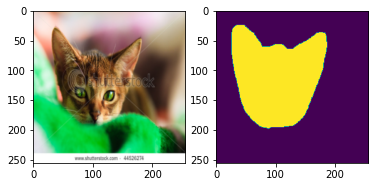

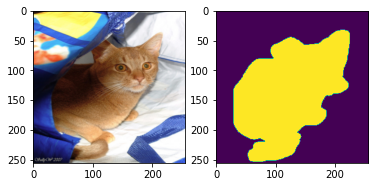

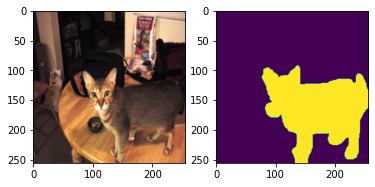

In [6]:
# init train, val, test sets
train_dataset = SimpleOxfordPetDataset(root, "train")
valid_dataset = SimpleOxfordPetDataset(root, "valid")
test_dataset = SimpleOxfordPetDataset(root, "test")

# It is a good practice to check datasets don`t intersects with each other
assert set(test_dataset.filenames).isdisjoint(set(train_dataset.filenames))
assert set(test_dataset.filenames).isdisjoint(set(valid_dataset.filenames))
assert set(train_dataset.filenames).isdisjoint(set(valid_dataset.filenames))

n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpu)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpu)

print(f"Batch size: {batch_size}\n")
print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}\n")
print(f"Train batch num: {len(train_dataloader)}")
print(f"Valid batch num: {len(valid_dataloader)}")
print(f"Test batch num: {len(test_dataloader)}")

## data check
sample = train_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = valid_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = test_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

# 4) Model

In [7]:
class Segmentation_Model(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
                        
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [8]:
## Encoder type
# Encoder = 'efficientnet-b5'  # 28M
# Encoder = 'mobilenet_v2'  # 2M
# Encoder = 'resnet34'  # 21M

## Decoder type
# Decoder = 'FPN'
# Decoder = 'Unet'
# Decoder = 'Linknet'
# Decoder = 'PSPNet'

In [9]:
model = Segmentation_Model(Decoder, Encoder, in_channels=3, out_classes=1)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth


  0%|          | 0.00/117M [00:00<?, ?B/s]

In [10]:
tt = next(iter(test_dataloader))['image'][0]
model.to('cpu')
model.eval()

Segmentation_Model(
  (model): DeepLabV3Plus(
    (encoder): EfficientNetEncoder(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d((0, 1, 0, 1))
      )
      (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
            (static_padding): ZeroPad2d((1, 1, 1, 1))
          )
          (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            48, 12, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            12, 48, kernel_size=(1, 1), stride=(1, 1)
            (stat

# 5) Training

strategy
- 'dp'  # multiple-gpus, 1 machine
- 'ddp'  # multiple-gpus across many machines (python script based)
- 'ddp_spawn'  # multiple-gpus across many machines (spawn based)
- 'ddp2'  # DP in a machine, DDP across machines
- 'horovod'  # multi-machine, multi-gpu, configured at runtime

In [11]:
## define model save & early stop
checkpoint_callback = ModelCheckpoint(
    dirpath=save_path,
    filename='{epoch}-{valid_dataset_iou:.3f}',
    verbose=True,
    save_last=False,
    save_top_k=3,
    monitor='valid_dataset_iou',
    mode='max'
)

early_stopping = EarlyStopping(
    monitor='valid_dataset_iou',
    patience=10,
    verbose=True,
    mode='max'
)

wandb_logger = WandbLogger(name=logger_name,project='segmentation')

In [12]:
## train!
trainer = pl.Trainer(
    # logger=wandb_logger,
    gpus=device, 
    max_epochs=num_epochs,
    amp_backend='native',  # for fp16
    precision=16,  # for fp16
    callbacks =[checkpoint_callback, early_stopping]
)

trainer.fit(
    model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=valid_dataloader,
)

# save & load last checkpoint
save_last_model_path = os.path.join(save_path, 'last_%.3f.pth'%(float(trainer.callback_metrics['valid_per_image_iou'].numpy())*100))
trainer.save_checkpoint(save_last_model_path)

INFO:pytorch_lightning.utilities.distributed:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type          | Params
------------------------------------------
0 | model   | DeepLabV3Plus | 29.5 M
1 | loss_fn | DiceLoss      | 0     
------------------------------------------
29.5 M    Trainable params
0         Non-trainable params
29.5 M    Total params
58.985    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_dataset_iou improved. New best score: 0.872
INFO:pytorch_lightning.utilities.distributed:Epoch 0, global step 206: valid_dataset_iou reached 0.87244 (best 0.87244), saving model to "/content/checkpoints/DeepLabV3Plus/epoch=0-valid_dataset_iou=0.872.ckpt" as top 3


Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_dataset_iou improved by 0.030 >= min_delta = 0.0. New best score: 0.902
INFO:pytorch_lightning.utilities.distributed:Epoch 1, global step 413: valid_dataset_iou reached 0.90217 (best 0.90217), saving model to "/content/checkpoints/DeepLabV3Plus/epoch=1-valid_dataset_iou=0.902.ckpt" as top 3


## Validation and test metrics

In [13]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
pprint(valid_metrics)

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

[{'valid_dataset_iou': 0.9021692872047424,
  'valid_per_image_iou': 0.8899886012077332}]


In [14]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
pprint(test_metrics)

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[{'test_dataset_iou': 0.9059602618217468,
  'test_per_image_iou': 0.8958913087844849}]


# 6) Model load check

In [15]:
# model redefine
model_load = Segmentation_Model(Decoder, Encoder, in_channels=3, out_classes=1)
# load the ckpt
ckpt = torch.load(save_last_model_path)
model_load.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

In [16]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
pprint(valid_metrics)

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

[{'valid_dataset_iou': 0.9021692872047424,
  'valid_per_image_iou': 0.8899886012077332}]


In [17]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
pprint(test_metrics)

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[{'test_dataset_iou': 0.9059602618217468,
  'test_per_image_iou': 0.8958913087844849}]


# 7) Result visualization

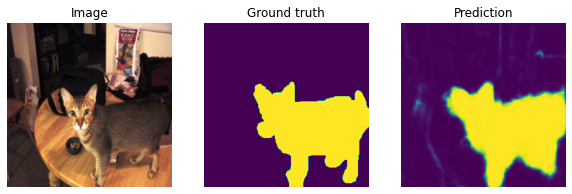

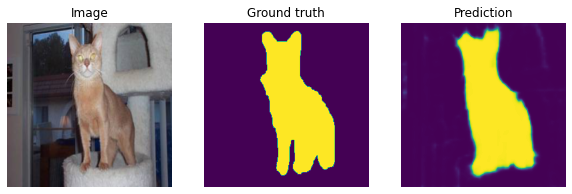

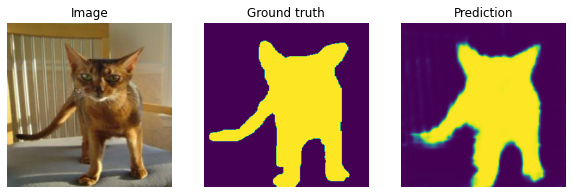

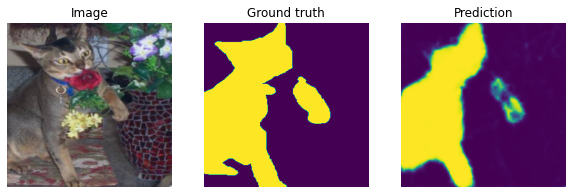

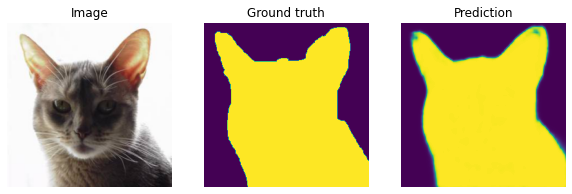

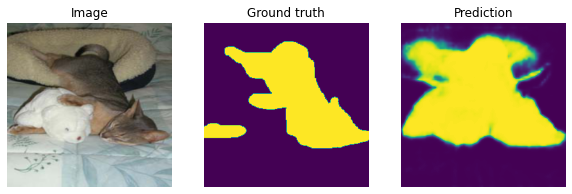

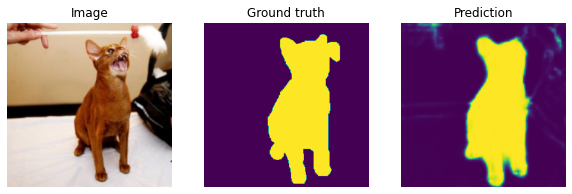

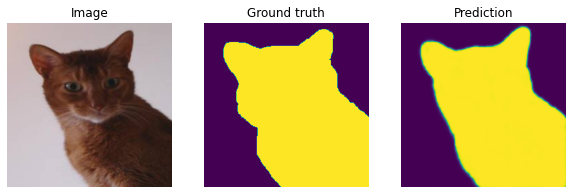

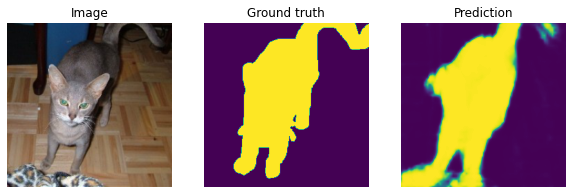

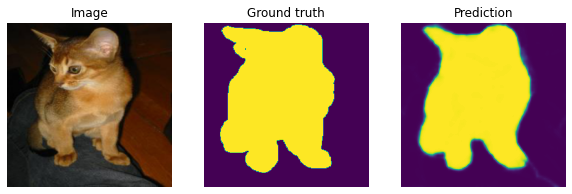

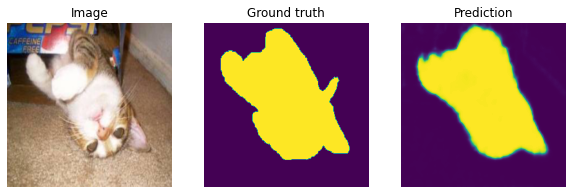

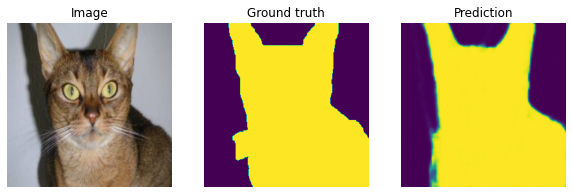

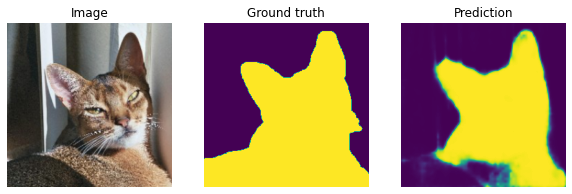

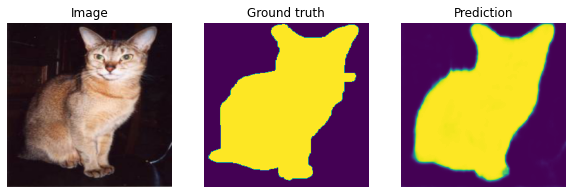

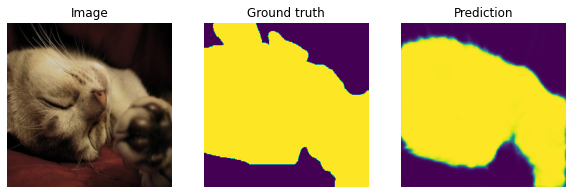

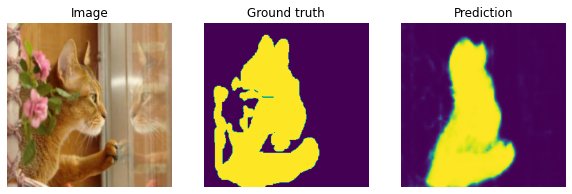

In [18]:
# Check the test image result
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()